# Pythagoras via Matrix

In [2]:
%matplotlib inline
import math
import random
import operator
import warnings
import numpy as np

from geneticprogramming import Baseset
from geneticprogramming import Individual
from geneticprogramming import Population

warnings.filterwarnings("ignore")

## Training data 

* a number of random matrices (2D floating points) on a plane

In [3]:
SAMPLE_SIZE = 50
PLANE_SIZE = 20.0
RANDOMPOINTS = [PLANE_SIZE * np.random.random_sample((1, 2)) for _ in range(SAMPLE_SIZE)]

## Base functions

* _get_ a value at a location from a matrix
* an _ephemeral integer_ - either 0 or 1
* _addition_ and _subtraction_ of floats
* _square_ and _square root_ of floats

In [4]:
def getValue(ndarray, idx):
    """Return the indexed value from the 1x2 numpy array"""
    return ndarray[0][idx]

square = lambda x: x ** 2
sqrt = lambda x: math.sqrt(abs(x))

bset = Baseset()
bset.add_ephemeral('E', lambda: random.randint(0, 1), int)
bset.add_primitive(getValue, [np.ndarray, int], float, name="get")
bset.add_primitive(operator.add, [float, float], float, name="add")
bset.add_primitive(operator.sub, [float, float], float, name="sub")
bset.add_primitive(square, [float], float, name="square")
bset.add_primitive(sqrt, [float], float, name="sqrt")

## Individuals
* consume a matrix (a 1x2 array of floats - x and y coordinates)
* return a float (the distance from the origin)
* scored by accumulating the error when applying the Training data

In [5]:
Individual.INTYPES = [np.ndarray]
Individual.OUTTYPE = float

def evaluate(individual):
    """sum of application of all the random points"""
    program = individual.compile()
    score = 0
    try:
        for point in RANDOMPOINTS:
            program_distance = program(point)
            true_distance = math.hypot(point[0][0], point[0][1])
            score += abs(true_distance - program_distance)
    except (OverflowError, RuntimeWarning):
        pass
    if math.isnan(score) or score == 0:
        score = 100000

    # accumulate the number of nodes actually used during a run by calling the adfs in the rpb
    nodes = 0
    for node in individual.trees[-1]:
        if node.name[:1] != 'F':
            nodes += 1
        else:
            nodes += len(individual.trees[int(node.name[1])])
    modifier = 1 + (-2 ** - (nodes / 250))

    return score + modifier,
Individual.evaluate = evaluate

## Population Evolution

In [6]:
Population.POPULATION_SIZE = 200       # Number of individuals in a generation
Population.MATE_MUTATE_CLONE = (60, 38, 2)   # ratio of individuals to mate, mutate, or clone
Population.CLONE_BEST = 10             # Number of best individuals to seed directly into offspring

Individual.MAX_ADFS = 4                # The maximum number of ADFs to generate
Individual.ADF_NARGS = (1, 5)          # min, max number of input arguments to adfs
Individual.GROWTH_TERM_PB = 0.3        # Probability of terminal when growing:
Individual.GROWTH_MAX_INIT_DEPTH = 5   # Maximum depth of initial growth
Individual.GROWTH_MAX_MUT_DEPTH = 3    # Maximum depth of mutation growth

NUM_GENERATIONS = 15

population = Population(bset)
for generation in range(NUM_GENERATIONS):
    population.evolve()

gen	avg	std	min    	max
0  	inf	nan	169.498	inf
1  	5.62833e+08	7.93964e+09	15.8184	1.12565e+11
2  	423.53     	916.245    	15.8184	9910.72    
3  	883.638    	2153.08    	0.0273451	11996.7    
4  	990.413    	2509.91    	0.0273451	11996.7    
5  	990.378    	2656.07    	0.0273451	11983.1    
6  	994.654    	2523.49    	0.0273451	11507.4    
7  	998.007    	2384.86    	0.0273451	11507.4    
8  	1015.93    	2446.26    	0.0273451	11507.4    
9  	1306.51    	2900.85    	0.0273451	11507.4    
10 	1192.83    	2905.12    	0.0273451	11507.4    
11 	1010.79    	2492.82    	0.0273451	11507.4    
12 	963.233    	2407.06    	0.0273451	11507.4    
13 	1116.6     	2693.88    	0.0273451	11507.4    
14 	1346.5     	2965.82    	0.0273451	11507.4    


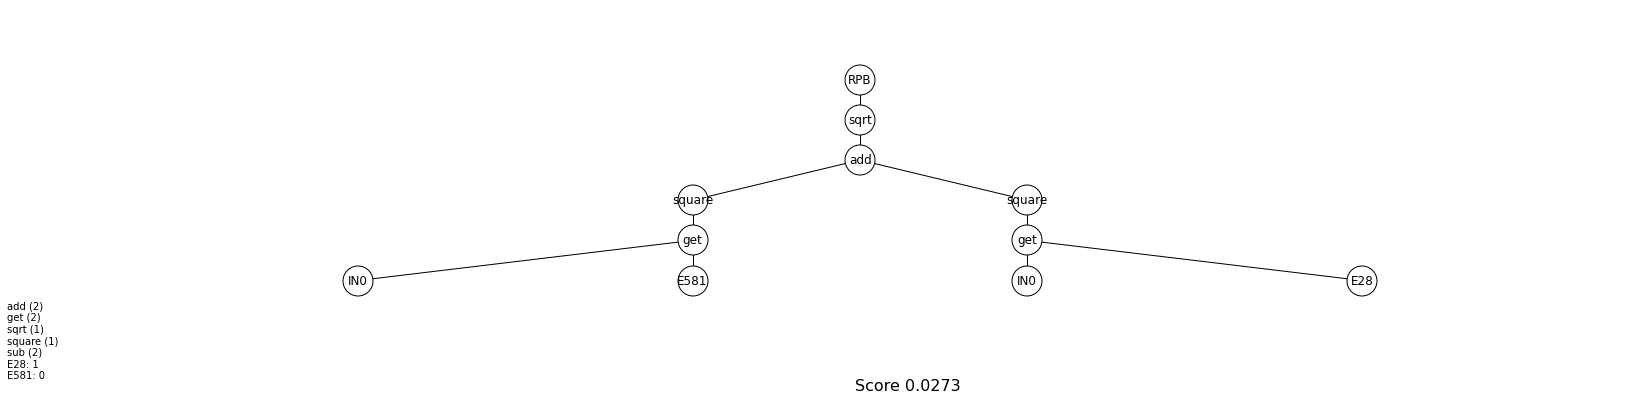

In [7]:
best = population[0]
best.draw()